In [38]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.model_selection import train_test_split
import cv2

In [23]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

cdata = torchvision.datasets.EMNIST(root='eminst', 
                                    split='letters', download=True)

In [29]:
print(cdata.classes)
print(str(len(cdata.classes))+ ' classes')

print('\nData size:')
print(cdata.data.shape)

images= cdata.data.view([124800,1,28,28]).float()
print('\nTensor data:')
print(images.shape)

print( torch.sum(cdata.targets==0))

torch.unique(cdata.targets)

['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
27 classes

Data size:
torch.Size([124800, 28, 28])

Tensor data:
torch.Size([124800, 1, 28, 28])
tensor(0)


tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26])

In [30]:
cdata.class_to_idx

letterCat = cdata.classes[1:]

labels = copy.deepcopy(cdata.targets)-1
print(labels.shape)

print(torch.sum(labels==0))
torch.unique(labels)

torch.Size([124800])
tensor(4800)


tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])

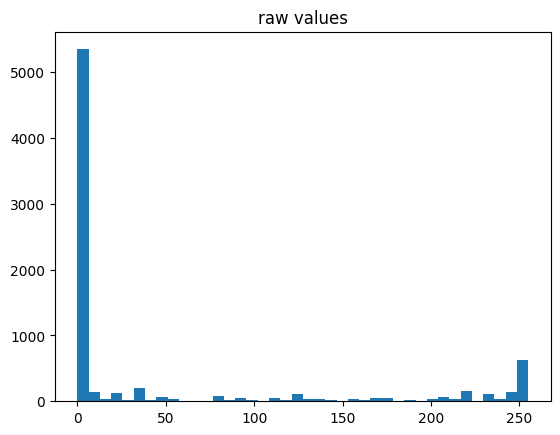

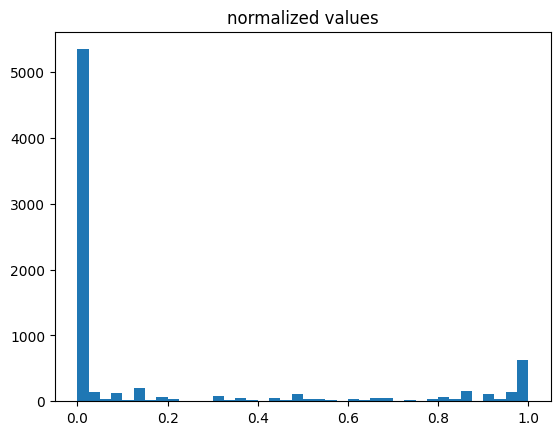

In [31]:
plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('raw values')
plt.show()

images /= torch.max(images)

plt.hist(images[:10,:,:,:].view(1,-1).detach(),40);
plt.title('normalized values')
plt.show()

In [32]:
train_data, test_data ,train_labels, test_labels = train_test_split(images, labels, test_size=.1)

train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data, test_labels)

batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [33]:
def makeTheNet(printtoggle=False):
    
    class emnistnet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            
            self.print = printtoggle
            
            #1st convolution layer
            self.conv1 = nn.Conv2d(1,6,3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(6)
            
            #2nd convoluton layer
            self.conv2 = nn.Conv2d(6,6,3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(6)
            
            self.fc1 = nn.Linear(7*7*6,50)
            self.fc2 = nn.Linear(50,26)
            
        def forward(self,x):
            if self.print: print(f'Input: {list(x.shape)}')
                
            x = F.max_pool2d(self.conv1(x),2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f'first CPR block{list(x.shape)}')
                
            x = F.max_pool2d(self.conv2(x),2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f'second CPR block{list(x.shape)}')
                
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print: print(f'vectorized: {list(x.shape)}')
                
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print: print(f'final output: {list(x.shape)}')
                
            return x
        
    net = emnistnet(printtoggle)

    loss = nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net,loss,optimizer


In [34]:
net,loss,optimizer = makeTheNet(True)

X,y = next(iter(train_loader))
yHat = net(X)

print('\nOutput size:')
print(yHat.shape)

L = loss(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(L)

Input: [32, 1, 28, 28]
first CPR block[32, 6, 14, 14]
second CPR block[32, 6, 7, 7]
vectorized: [32, 294]
final output: [32, 26]

Output size:
torch.Size([32, 26])
 
Loss:
tensor(3.2626, grad_fn=<NllLossBackward0>)


In [35]:
def train():
    epochs = 10
    net, loss, optimizer = makeTheNet()
    net.to(device)
    
    trainloss = torch.zeros(epochs)
    testloss = torch.zeros(epochs)
    trainerr = torch.zeros(epochs)
    testerr = torch.zeros(epochs)
    
    for epochi in range(epochs):
        net.train()
        batchloss = []
        batcherr = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            
            yHat = net(X)
            L = loss(yHat, y)
            
            optimizer.zero_grad()
            L.backward()
            optimizer.step()
            
            batchloss.append(L.item())
            batcherr.append(torch.mean((torch.argmax(yHat, axis=1) != y).float()).item())
            
        trainloss[epochi] = np.mean(batchloss)
        trainerr[epochi] = 100 * np.mean(batcherr)
        
        net.eval()
        X, y = next(iter(test_loader))
        X = X.to(device)
        y = y.to(device)
            
        with torch.no_grad():
            yHat = net(X)
            L = loss(yHat, y)
            
        testloss[epochi] = L.item()
        testerr[epochi] = torch.mean((torch.argmax(yHat, axis=1) != y).float()).item() * 100
        
    return trainloss, testloss, trainerr, testerr, net

In [36]:
trainloss, testloss, trainerr, testerr, net= train()

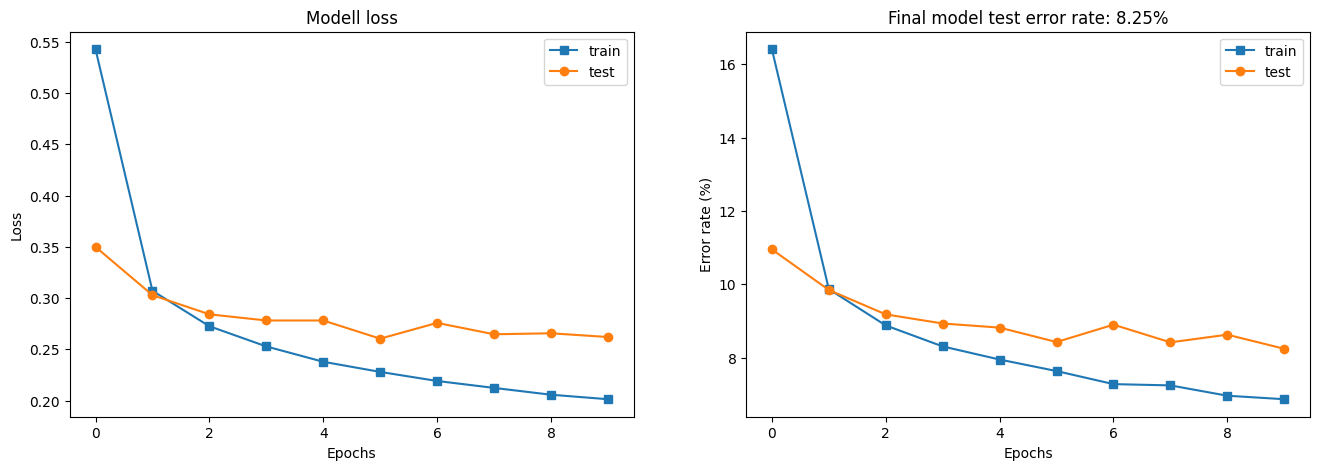

In [37]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainloss, 's-', label='train')
ax[0].plot(testloss, 'o-', label='test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Modell loss')
ax[0].legend()

ax[1].plot(trainerr, 's-', label='train')
ax[1].plot(testerr, 'o-', label='test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rate (%)')
ax[1].set_title(f'Final model test error rate: {testerr[-1]:.2f}%')
ax[1].legend()

plt.show()

In [64]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F  # Import this module for max_pool2d
from torchvision import transforms

# Load and preprocess the extracted letter images
target_width = 224
target_height = 224
letters_preprocessed = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    if w > 10 and h > 10: 
        letter = noisy_image[y:y+h, x:x+w]
        
        # Resize the letter image to match the input size of your model
        letter_resized = cv2.resize(letter, (target_width, target_height))
        
        # Preprocess the letter image (normalize, convert to tensor)
        preprocess = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])  # Use the same values as during training
        ])
        letter_preprocessed = preprocess(letter_resized).unsqueeze(0)  # Add a batch dimension
        
        letters_preprocessed.append(letter_preprocessed)

# Convert the list of preprocessed letter images to a tensor
letters_tensor = torch.cat(letters_preprocessed, dim=0)

# Set the model to evaluation mode
net.eval()

# Move the tensor images to the device (CPU or GPU)
letters_tensor = letters_tensor.to(device)

# Forward pass to get predictions
with torch.no_grad():
    outputs = net(letters_tensor)

# Get the predicted labels for the images
predicted_labels = torch.argmax(outputs, dim=1).tolist()

print(predicted_labels)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x18816 and 294x50)

In [61]:
from PIL import Image
import torch
import torchvision.transforms.functional as F

# Load the RGB image using PIL (replace 'path_to_image' with the actual image file path)
image = letters[0]

# Convert the RGB image to grayscale
gray_image = F.to_grayscale(image)

# Preprocess the grayscale image (resize, normalize, etc.)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])
preprocessed_image = preprocess(gray_image).unsqueeze(0)  # Add a batch dimension

# Move the preprocessed image to the device (CPU or GPU)
preprocessed_image = preprocessed_image.to(device)

# Set the model to evaluation mode
net.eval()

# Forward pass to get predictions
with torch.no_grad():
    outputs = net(preprocessed_image)

# Get the predicted label for the image
predicted_label = torch.argmax(outputs, dim=1).item()

print("Predicted label:", predicted_label)


TypeError: Input should be PIL Image